# make KDEs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from datetime import datetime, timedelta
import os
import pickle

from KDEpy import FFTKDE

import helper_functions

In [2]:
import matplotlib
matplotlib.style.use('default')

# read data

In [3]:
# note: 'load_from_pickle' is defined in helper_functions.py
[ERA5_ECMWF, 
 ERA5_IITM, 
 ERA5_ECMWF_deps, 
 ERA5_ECMWF_lows,
 ERA5_IITM_deps, 
 ERA5_IITM_lows] = helper_functions.load_from_pickle('data/update/models_joined_with_era5.pickle')

In [4]:
[MERRA2_ECMWF,
 MERRA2_IITM] = helper_functions.load_from_pickle('data/update/models_joined_with_merra2.pickle')

# helper methods

In [5]:
# turn the histogram into a PDF

# see https://kdepy.readthedocs.io/en/latest/examples.html
# scroll down to 'Boundary Correction by Mirroring'
# BUT we actually DO NOT want to do a boundary correction here b/c 
#    intensity bias doesn't have to start at 0

def mirrorKDE(data, mirror=False, low_bound=0):
    
    kde = FFTKDE(bw='silverman', kernel='triweight')
    x, y = kde.fit(data)(2**10) # Two-step proceudure to get bw
    #plt.plot(x, y, label='FFTKDE')
    #plt.scatter(dayOneDist, np.zeros_like(dayOneDist), marker='|')
    
    if mirror==True:
        
        # Mirror the data about the domain boundary (use for position bias)
        mirroredData = np.concatenate((data, 2 * low_bound - np.array(data)))

        # Compute KDE using the bandwidth found, and thrice as many grid points
        x, y = FFTKDE(bw=kde.bw, kernel='triweight').fit(mirroredData)(2**11)
        y[x<=low_bound] = 0 # Set the KDE to zero outside of the domain
        y = y * 2  # Double the y-values to get integral of ~1
        
    return x, y

In [6]:
# example of use:
# fig, ax = plt.subplots()
# make_KDE_plot_by_day(ax, concatted_df, 'PressureDrop', 'Intensity Bias (Pa)', 'title', linestyle='-',
#                      label_prefix='ECMWF')

def make_KDE_plot_by_day(ax, concatted_df, var, xlabel, title, linestyle, label_prefix, xlims,
                         mirror=False, low_bound=0, ylims=[0, 0.007], divide=False):
    
    day1 = concatted_df[concatted_df['ForecastLeadTime'] <= 24]
    day2 = concatted_df[concatted_df['ForecastLeadTime'].between(24, 48, inclusive='right')]
    day3 = concatted_df[concatted_df['ForecastLeadTime'].between(48, 72, inclusive='right')]
    # dayL = concatted_df[concatted_df['ForecastLeadTime'] > 72] # Suhas said skip
    
    x1, y1 = mirrorKDE(day1[var+'Bias'].values, mirror, low_bound)
    x2, y2 = mirrorKDE(day2[var+'Bias'].values, mirror, low_bound)
    x3, y3 = mirrorKDE(day3[var+'Bias'].values, mirror, low_bound)
    # xL, yL = mirrorKDE(dayL[var+'Bias'].values, mirror, low_bound)
    
    if not divide:
        ax.plot(x1, y1, label=label_prefix+' day 1', color='C0', linestyle=linestyle)
        ax.plot(x2, y2, label=label_prefix+' day 2', color='C1', linestyle=linestyle)
        ax.plot(x3, y3, label=label_prefix+' day 3', color='C2', linestyle=linestyle) 
        # ax.plot(xL, yL, label=label_prefix+' day >3', color='r', linestyle=linestyle)
    else:
        ax.plot(x1/divide, y1, label=label_prefix+' day 1', color='C0', linestyle=linestyle)
        ax.plot(x2/divide, y2, label=label_prefix+' day 2', color='C1', linestyle=linestyle)
        ax.plot(x3/divide, y3, label=label_prefix+' day 3', color='C2', linestyle=linestyle)
    ax.grid(b=True)
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.legend()
    
    ax.set_xlabel(xlabel, size=14)
    # ax.set_ylabel('Density')
    ax.set_title(title)

In [7]:
# make a 3 panel KDE plot. Common use case:
#    first panel: ECMWF vs. IITM, all systems
#    second panel: ECMWF depressions vs. lows
#    third panel: IITM depressions vs. lows

# example of use
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4.8))

# three_panel_KDE_plot(ax1, ax2, ax3,
#                      df1 = ecmwf_intensity_bias, df2 = iitm_intensity_bias,
#                      df3 = ecmwf_deps_intensity_bias, df4 = ecmwf_lows_intensity_bias,
#                      df5 = iitm_deps_intensity_bias, df6 = iitm_lows_intensity_bias,
#                      var=var, xlabel='Intensity bias (Pa)',
#                      title1='KDE for Intensity Bias: ECMWF vs. IITM',
#                      title2='KDE for Intensity Bias: ECMWF Depressions vs. Lows',
#                      title3='KDE for Intensity Bias: IITM Depressions vs. Lows',
#                      label_prefix1='ECMWF', label_prefix2='IITM',
#                      label_prefix3='deps', label_prefix4='lows',
#                      label_prefix5='deps', label_prefix6='lows')

def three_panel_KDE_plot(ax1, ax2, ax3, df1, df2, df3, df4, df5, df6, var, xlabel, xlims,
                         title1, title2, title3,
                         label_prefix1, label_prefix2, 
                         label_prefix3, label_prefix4,
                         label_prefix5, label_prefix6,
                         mirror=False, low_bound=0):
    
    make_KDE_plot_by_day(ax1, df1, var, xlabel, title1, '-', label_prefix1, xlims, mirror, low_bound)
    make_KDE_plot_by_day(ax1, df2, var, xlabel, title1, '--', label_prefix2, xlims, mirror, low_bound)
    
    make_KDE_plot_by_day(ax2, df3, var, xlabel, title2, '-', label_prefix3, xlims, mirror, low_bound)
    make_KDE_plot_by_day(ax2, df4, var, xlabel, title2, '--', label_prefix4, xlims, mirror, low_bound)
    
    make_KDE_plot_by_day(ax3, df5, var, xlabel, title3, '-', label_prefix5, xlims, mirror, low_bound)
    make_KDE_plot_by_day(ax3, df6, var, xlabel, title3, '--', label_prefix6, xlims, mirror, low_bound)

# Position Bias KDE

In [8]:
def get_df_for_position_bias_KDE(dic, model_name, observation_name, var):
    
    # the three functions called here are defined in helper_functions.py
    dic_with_leadtime = helper_functions.add_leadtime_column(dic)
    dic_with_position_bias = helper_functions.add_position_bias_columns(dic_with_leadtime, model_name, 
                                                                        observation_name)
    concatted_df = helper_functions.concat_bias(dic_with_position_bias, model_name, 
                                                observation_name, var)
    
    return concatted_df

## models vs. ERA5

In [11]:
observation_name = 'era5'
var = 'Distance'

ecmwf_position_bias = get_df_for_position_bias_KDE(ERA5_ECMWF, 'ecmwf', 
                                                   observation_name, var=var)
iitm_position_bias = get_df_for_position_bias_KDE(ERA5_IITM, 'iitm', 
                                                  observation_name, var=var)

ecmwf_deps_position_bias = get_df_for_position_bias_KDE(ERA5_ECMWF_deps, 'ecmwf',
                                                        observation_name, var=var)
ecmwf_lows_position_bias = get_df_for_position_bias_KDE(ERA5_ECMWF_lows, 'ecmwf',
                                                        observation_name, var)

iitm_deps_position_bias = get_df_for_position_bias_KDE(ERA5_IITM_deps, 'iitm',
                                                       observation_name, var)
iitm_lows_position_bias = get_df_for_position_bias_KDE(ERA5_IITM_lows, 'iitm',
                                                       observation_name, var)

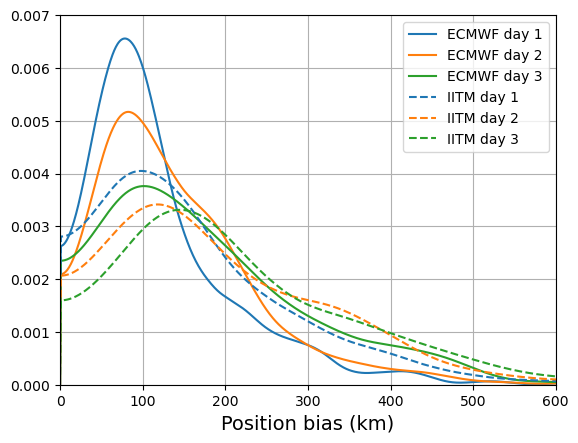

In [13]:
fig, ax = plt.subplots()
make_KDE_plot_by_day(ax, 
                     concatted_df=ecmwf_position_bias, 
                     var='Distance', 
                     xlabel='Position bias (km)',
                     title=None,
                     # title='KDE for Position Bias: ECMWF vs. IITM',
                     linestyle='-', 
                     label_prefix='ECMWF', 
                     xlims=[-1, 600], 
                     mirror=True, low_bound=0)

make_KDE_plot_by_day(ax, 
                     concatted_df=iitm_position_bias, 
                     var='Distance', 
                     xlabel='Position bias (km)', 
                     title=None,
                     # title='KDE for Position Bias: ECMWF vs. IITM',
                     linestyle='--', 
                     label_prefix='IITM', 
                     xlims=[-1, 600], 
                     mirror=True, low_bound=0)

# plt.savefig('Figures/figures_08212022/KDE_position_bias.pdf', 
#             format='pdf', bbox_inches='tight')

# This section is not being included in the manuscript. Code here therefore has not been updated. 

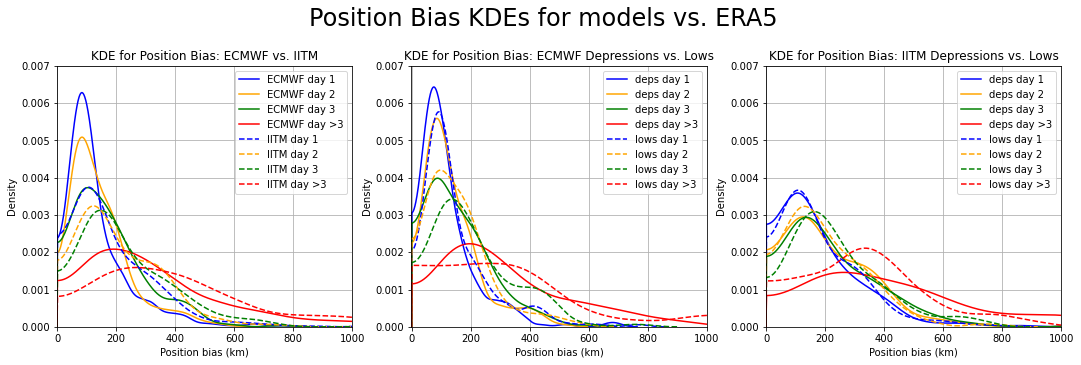

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4.8))

three_panel_KDE_plot(ax1, ax2, ax3,
                     df1 = ecmwf_position_bias, df2 = iitm_position_bias,
                     df3 = ecmwf_deps_position_bias, df4 = ecmwf_lows_position_bias,
                     df5 = iitm_deps_position_bias, df6 = iitm_lows_position_bias,
                     var='Distance', xlabel='Position bias (km)', xlims=[-1, 1000],
                     title1='KDE for Position Bias: ECMWF vs. IITM',
                     title2='KDE for Position Bias: ECMWF Depressions vs. Lows',
                     title3='KDE for Position Bias: IITM Depressions vs. Lows',
                     label_prefix1='ECMWF', label_prefix2='IITM',
                     label_prefix3='deps', label_prefix4='lows',
                     label_prefix5='deps', label_prefix6='lows',
                     mirror=True, low_bound=0)

fig.suptitle('Position Bias KDEs for models vs. ERA5', fontsize=24, y=1.05)
plt.savefig('Figures/KDE_position_bias.pdf', format='pdf', bbox_inches='tight')

## models vs. MERRA2

In [12]:
observation_name = 'merra2'
var = 'Distance'

ecmwf_position_bias = get_df_for_position_bias_KDE(MERRA2_ECMWF, 'ecmwf', 
                                                   observation_name, var=var)
iitm_position_bias = get_df_for_position_bias_KDE(MERRA2_IITM, 'iitm', 
                                                  observation_name, var=var)

ecmwf_deps_position_bias = get_df_for_position_bias_KDE(MERRA2_ECMWF_deps, 'ecmwf',
                                                        observation_name, var=var)
ecmwf_lows_position_bias = get_df_for_position_bias_KDE(MERRA2_ECMWF_lows, 'ecmwf',
                                                        observation_name, var)

iitm_deps_position_bias = get_df_for_position_bias_KDE(MERRA2_IITM_deps, 'iitm',
                                                       observation_name, var)
iitm_lows_position_bias = get_df_for_position_bias_KDE(MERRA2_IITM_lows, 'iitm',
                                                       observation_name, var)

Text(0.5, 1.05, 'Position Bias KDEs for models vs. MERRA2')

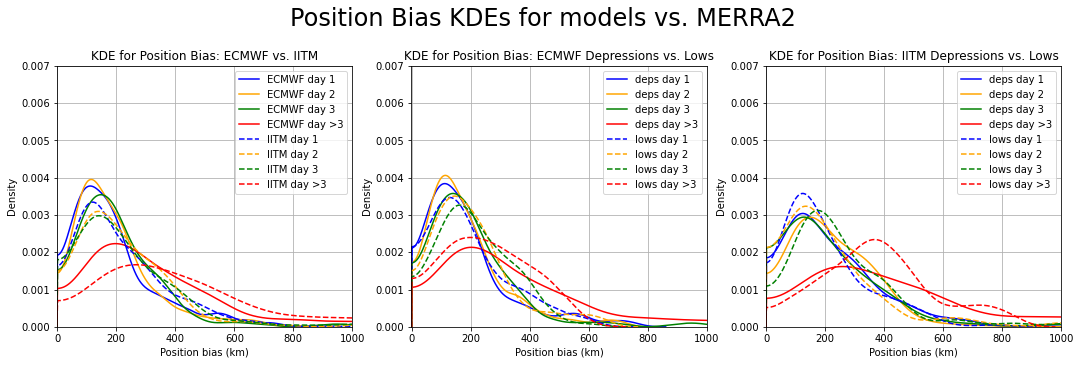

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4.8))

three_panel_KDE_plot(ax1, ax2, ax3,
                     df1 = ecmwf_position_bias, df2 = iitm_position_bias,
                     df3 = ecmwf_deps_position_bias, df4 = ecmwf_lows_position_bias,
                     df5 = iitm_deps_position_bias, df6 = iitm_lows_position_bias,
                     var='Distance', xlabel='Position bias (km)', xlims=[-1, 1000],
                     title1='KDE for Position Bias: ECMWF vs. IITM',
                     title2='KDE for Position Bias: ECMWF Depressions vs. Lows',
                     title3='KDE for Position Bias: IITM Depressions vs. Lows',
                     label_prefix1='ECMWF', label_prefix2='IITM',
                     label_prefix3='deps', label_prefix4='lows',
                     label_prefix5='deps', label_prefix6='lows',
                     mirror=True, low_bound=0)

fig.suptitle('Position Bias KDEs for models vs. MERRA2', fontsize=24, y=1.05)

# Intensity Bias KDE

In [9]:
def get_df_for_intensity_bias_KDE(dic, model_name, observation_name, var):
    
    # the three functions called here are defined in helper_functions.py
    dic_with_leadtime = helper_functions.add_leadtime_column(dic)
    dic_with_bias = helper_functions.add_bias_columns(dic_with_leadtime, model_name, 
                                                      observation_name, var)
    concatted_df = helper_functions.concat_bias(dic_with_bias, model_name, observation_name, var)
    
    return concatted_df

## models vs. ERA5

In [10]:
observation_name = 'era5'
var = 'PressureDrop'

ecmwf_intensity_bias = get_df_for_intensity_bias_KDE(ERA5_ECMWF, 'ecmwf', 
                                                     observation_name, var=var)
iitm_intensity_bias = get_df_for_intensity_bias_KDE(ERA5_IITM, 'iitm', 
                                                    observation_name, var=var)

ecmwf_deps_intensity_bias = get_df_for_intensity_bias_KDE(ERA5_ECMWF_deps, 'ecmwf', 
                                                          observation_name, var=var)
ecmwf_lows_intensity_bias = get_df_for_intensity_bias_KDE(ERA5_ECMWF_lows, 'ecmwf', 
                                                          observation_name, var=var)

iitm_deps_intensity_bias = get_df_for_intensity_bias_KDE(ERA5_IITM_deps, 'iitm', 
                                                         observation_name, var=var)
iitm_lows_intensity_bias = get_df_for_intensity_bias_KDE(ERA5_IITM_lows, 'iitm', 
                                                         observation_name, var=var)


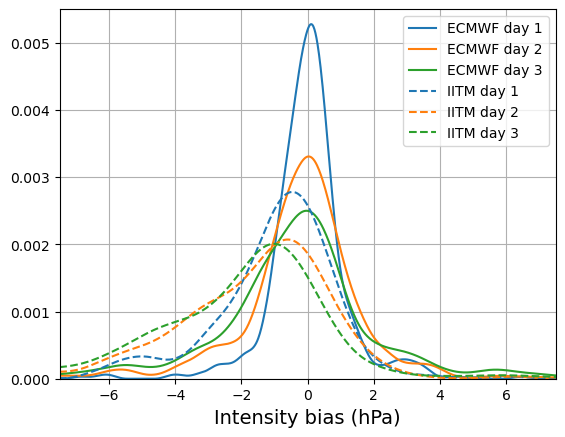

In [15]:
fig, ax = plt.subplots()
make_KDE_plot_by_day(ax, 
                     concatted_df=ecmwf_intensity_bias, 
                     var='PressureDrop', 
                     xlabel='Intensity bias (hPa)',
                     title=None,
                     # title='KDE for Intensity Bias: ECMWF vs. IITM',
                     linestyle='-', 
                     label_prefix='ECMWF', 
                     xlims=[-7.5, 7.5],
                     ylims=[0, .005],
                     divide=100)

make_KDE_plot_by_day(ax, 
                     concatted_df=iitm_intensity_bias, 
                     var='PressureDrop', 
                     xlabel='Intensity bias (hPa)', 
                     title=None,
                     # title='KDE for Intensity Bias: ECMWF vs. IITM',
                     linestyle='--', 
                     label_prefix='IITM', 
                     xlims=[-7.5, 7.5],
                     ylims=[0, .0055],
                     divide=100)

# plt.savefig('Figures/figures_08212022/KDE_intensity_bias.pdf', 
#             format='pdf', bbox_inches='tight')

## Things below this are not being included in the manuscript

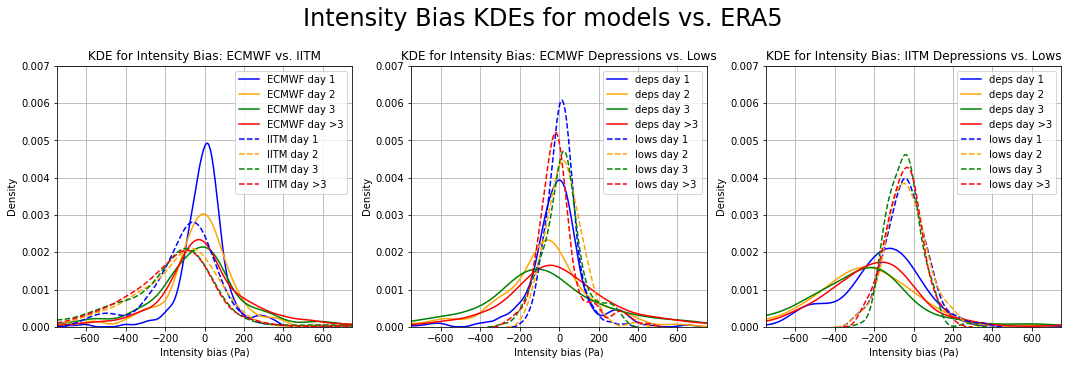

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4.8))

three_panel_KDE_plot(ax1, ax2, ax3,
                     df1 = ecmwf_intensity_bias, df2 = iitm_intensity_bias,
                     df3 = ecmwf_deps_intensity_bias, df4 = ecmwf_lows_intensity_bias,
                     df5 = iitm_deps_intensity_bias, df6 = iitm_lows_intensity_bias,
                     var='PressureDrop', xlabel='Intensity bias (Pa)', xlims=[-750, 750],
                     title1='KDE for Intensity Bias: ECMWF vs. IITM',
                     title2='KDE for Intensity Bias: ECMWF Depressions vs. Lows',
                     title3='KDE for Intensity Bias: IITM Depressions vs. Lows',
                     label_prefix1='ECMWF', label_prefix2='IITM',
                     label_prefix3='deps', label_prefix4='lows',
                     label_prefix5='deps', label_prefix6='lows')

fig.suptitle('Intensity Bias KDEs for models vs. ERA5', fontsize=24, y=1.05)
plt.savefig('Figures/KDE_intensity_bias.pdf', format='pdf', bbox_inches='tight')

## models vs. MERRA2

In [17]:
observation_name = 'merra2'
var = 'PressureDrop'

ecmwf_intensity_bias = get_df_for_intensity_bias_KDE(MERRA2_ECMWF, 'ecmwf', 
                                                     observation_name, var=var)
iitm_intensity_bias = get_df_for_intensity_bias_KDE(MERRA2_IITM, 'iitm', 
                                                    observation_name, var=var)

ecmwf_deps_intensity_bias = get_df_for_intensity_bias_KDE(MERRA2_ECMWF_deps, 'ecmwf', 
                                                          observation_name, var=var)
ecmwf_lows_intensity_bias = get_df_for_intensity_bias_KDE(MERRA2_ECMWF_lows, 'ecmwf', 
                                                          observation_name, var=var)

iitm_deps_intensity_bias = get_df_for_intensity_bias_KDE(MERRA2_IITM_deps, 'iitm', 
                                                         observation_name, var=var)
iitm_lows_intensity_bias = get_df_for_intensity_bias_KDE(MERRA2_IITM_lows, 'iitm', 
                                                         observation_name, var=var)

Text(0.5, 1.05, 'Intensity Bias KDEs for models vs. MERRA2')

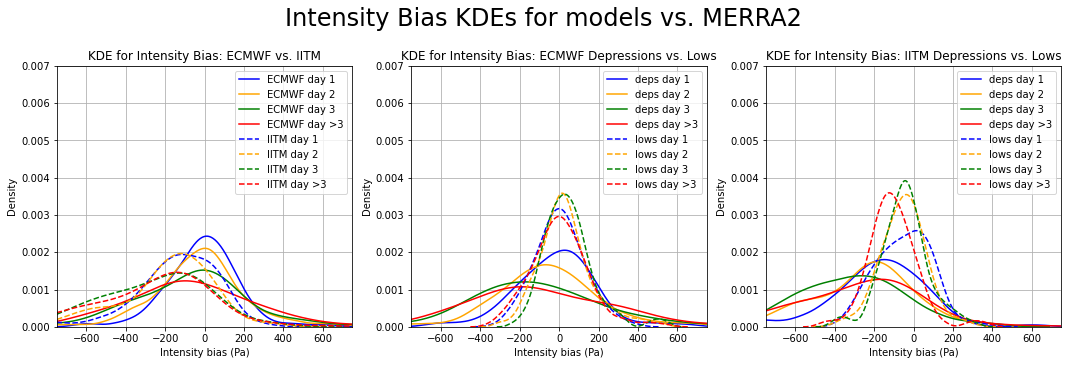

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4.8))

three_panel_KDE_plot(ax1, ax2, ax3,
                     df1 = ecmwf_intensity_bias, df2 = iitm_intensity_bias,
                     df3 = ecmwf_deps_intensity_bias, df4 = ecmwf_lows_intensity_bias,
                     df5 = iitm_deps_intensity_bias, df6 = iitm_lows_intensity_bias,
                     var='PressureDrop', xlabel='Intensity bias (Pa)', xlims=[-750, 750],
                     title1='KDE for Intensity Bias: ECMWF vs. IITM',
                     title2='KDE for Intensity Bias: ECMWF Depressions vs. Lows',
                     title3='KDE for Intensity Bias: IITM Depressions vs. Lows',
                     label_prefix1='ECMWF', label_prefix2='IITM',
                     label_prefix3='deps', label_prefix4='lows',
                     label_prefix5='deps', label_prefix6='lows')

fig.suptitle('Intensity Bias KDEs for models vs. MERRA2', fontsize=24, y=1.05)